In [5]:
# Import required libraries
import sys
import os

# Add the src directory to the Python path so we can import fourier module
# From examples/ we need to go up two levels: ../.. to get to src/
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, src_path)

import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from graphmol.spectrum_mol import (
    build_topological_laplacian,
    compute_charge_spectrum_from_laplacian as compute_charge_spectrum,
    compute_mol_spectrum as compute_charge_spectrum,
    plot_charge_spectrum,
    analyze_spectrum_features,
)
plt.style.use('seaborn-v0_8')

print("All imports successful!")
print(f"Added path: {src_path}")
print(f"Current working directory: {os.getcwd()}")


All imports successful!
Added path: /home/vpalacio/Documents/repos/PolarNematic/src
Current working directory: /home/vpalacio/Documents/repos/PolarNematic/src/graphmol/examples


Benzene: 12 atoms
Caffeine: 24 atoms


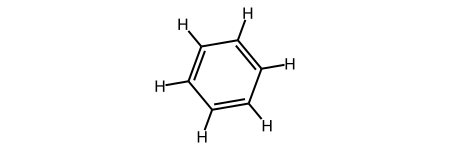

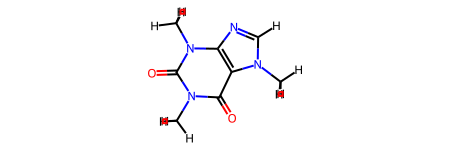

In [6]:

# Number of conformers
n_conf=5
# Generate conformers
params = AllChem.ETKDGv3()
params.randomSeed = 1234567890
params.numThreads = 0  # Use all available CPUs
params.enforceChirality = True
params.useExpTorsionAnglePrefs = True
params.useBasicKnowledge = True
# Optimize using UFF
max_iters=2500


# Create benzene molecule from SMILES
benzene_smiles = "c1ccccc1"
mol_benzene = Chem.MolFromSmiles(benzene_smiles)
# Add hydrogens and generate 3D coordinates
mol_benzene = Chem.AddHs(mol_benzene)

 
# Generate conformers
n_generated = AllChem.EmbedMultipleConfs(mol_benzene, numConfs=n_conf, params=params)
res = AllChem.MMFFOptimizeMoleculeConfs(mol_benzene, maxIters=max_iters)
                                        

# Create caffeine molecule from SMILES  
caffeine_smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
mol_caffeine = Chem.MolFromSmiles(caffeine_smiles)
mol_caffeine = Chem.AddHs(mol_caffeine)
n_generated = AllChem.EmbedMultipleConfs(mol_caffeine, numConfs=n_conf, params=params)
res = AllChem.MMFFOptimizeMoleculeConfs(mol_caffeine, maxIters=max_iters)

print(f"Benzene: {mol_benzene.GetNumAtoms()} atoms")
print(f"Caffeine: {mol_caffeine.GetNumAtoms()} atoms")

# Display molecules
display(mol_benzene)
display(mol_caffeine)


In [9]:
# Compute Gasteiger charges
Chem.rdPartialCharges.ComputeGasteigerCharges(mol_benzene)
Chem.rdPartialCharges.ComputeGasteigerCharges(mol_caffeine)

# Extract charges
charges_benzene = np.array([float(atom.GetProp('_GasteigerCharge')) for atom in mol_benzene.GetAtoms()])
charges_caffeine = np.array([float(atom.GetProp('_GasteigerCharge')) for atom in mol_caffeine.GetAtoms()])

print("Benzene charges:")
for i, charge in enumerate(charges_benzene):
    atom = mol_benzene.GetAtomWithIdx(i)
    print(f"Atom {i} ({atom.GetSymbol()}): {charge:.4f}")

print(f"\nBenzene - Total charge: {np.sum(charges_benzene):.6f}, Std dev: {np.std(charges_benzene):.4f}")
print(f"Caffeine - Total charge: {np.sum(charges_caffeine):.6f}, Std dev: {np.std(charges_caffeine):.4f}")


Benzene charges:
Atom 0 (C): -0.0623
Atom 1 (C): -0.0623
Atom 2 (C): -0.0623
Atom 3 (C): -0.0623
Atom 4 (C): -0.0623
Atom 5 (C): -0.0623
Atom 6 (H): 0.0623
Atom 7 (H): 0.0623
Atom 8 (H): 0.0623
Atom 9 (H): 0.0623
Atom 10 (H): 0.0623
Atom 11 (H): 0.0623

Benzene - Total charge: 0.000000, Std dev: 0.0623
Caffeine - Total charge: -0.000000, Std dev: 0.1726


Eigenvalue ranges (should be 0-2 for normalized Laplacian):
Benzene eigenvalues: [0.000, 2.000]
Caffeine eigenvalues: [-0.000, 1.982]


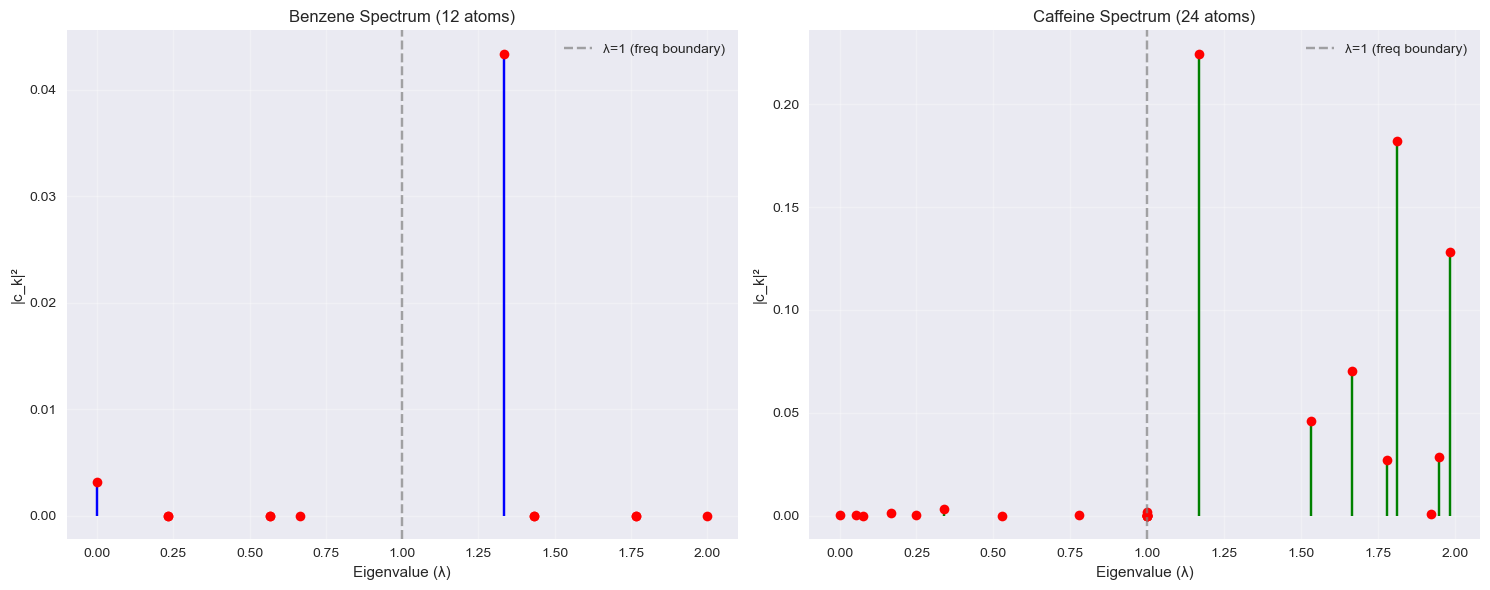

In [10]:
# Compute charge spectra using normalized Laplacian
eigenvalues_bz, squared_coeffs_bz = compute_charge_spectrum(mol_benzene, charges_benzene)
eigenvalues_caf, squared_coeffs_caf = compute_charge_spectrum(mol_caffeine, charges_caffeine)

print("Eigenvalue ranges (should be 0-2 for normalized Laplacian):")
print(f"Benzene eigenvalues: [{eigenvalues_bz.min():.3f}, {eigenvalues_bz.max():.3f}]")
print(f"Caffeine eigenvalues: [{eigenvalues_caf.min():.3f}, {eigenvalues_caf.max():.3f}]")

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Benzene spectrum
ax1.stem(eigenvalues_bz, squared_coeffs_bz, basefmt=" ", linefmt='b-', markerfmt='ro')
ax1.set_xlabel('Eigenvalue (λ)')
ax1.set_ylabel('|c_k|²')
ax1.set_title(f'Benzene Spectrum ({len(eigenvalues_bz)} atoms)')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=1.0, color='gray', linestyle='--', alpha=0.7, label='λ=1 (freq boundary)')
ax1.legend()

# Caffeine spectrum  
ax2.stem(eigenvalues_caf, squared_coeffs_caf, basefmt=" ", linefmt='g-', markerfmt='ro')
ax2.set_xlabel('Eigenvalue (λ)')
ax2.set_ylabel('|c_k|²')
ax2.set_title(f'Caffeine Spectrum ({len(eigenvalues_caf)} atoms)')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=1.0, color='gray', linestyle='--', alpha=0.7, label='λ=1 (freq boundary)')
ax2.legend()

plt.tight_layout()
plt.show()


In [11]:
# Analyze spectral features for both molecules
analysis_bz = analyze_spectrum_features(eigenvalues_bz, squared_coeffs_bz)
analysis_caf = analyze_spectrum_features(eigenvalues_caf, squared_coeffs_caf)

print("=" * 70)
print("NORMALIZED LAPLACIAN SPECTRUM COMPARISON")
print("=" * 70)

comparison_metrics = [
    ("Metric", "Benzene", "Caffeine"),
    ("─" * 20, "─" * 10, "─" * 10),
    ("Atoms", mol_benzene.GetNumAtoms(), mol_caffeine.GetNumAtoms()),
    ("Eigenvalue range", f"[{eigenvalues_bz.min():.2f}, {eigenvalues_bz.max():.2f}]", 
     f"[{eigenvalues_caf.min():.2f}, {eigenvalues_caf.max():.2f}]"),
    ("Charge std dev", f"{np.std(charges_benzene):.4f}", f"{np.std(charges_caffeine):.4f}"),
    ("Total energy", f"{analysis_bz['total_energy']:.4f}", f"{analysis_caf['total_energy']:.4f}"),
    ("DC fraction", f"{analysis_bz['dc_fraction']:.3f}", f"{analysis_caf['dc_fraction']:.3f}"),
    ("High freq fraction (λ>1)", f"{analysis_bz['high_freq_fraction']:.3f}", f"{analysis_caf['high_freq_fraction']:.3f}"),
    ("Spectral centroid", f"{analysis_bz['spectral_centroid']:.3f}", f"{analysis_caf['spectral_centroid']:.3f}"),
    ("Significant peaks", analysis_bz['n_significant_components'], analysis_caf['n_significant_components'])
]

for metric, bz_val, caf_val in comparison_metrics:
    print(f"{metric:20s} | {str(bz_val):15s} | {str(caf_val):15s}")



NORMALIZED LAPLACIAN SPECTRUM COMPARISON
Metric               | Benzene         | Caffeine       
──────────────────── | ──────────      | ──────────     
Atoms                | 12              | 24             
Eigenvalue range     | [0.00, 2.00]    | [-0.00, 1.98]  
Charge std dev       | 0.0623          | 0.1726         
Total energy         | 0.0465          | 0.7148         
DC fraction          | 0.067           | 0.000          
High freq fraction (λ>1) | 0.933           | 0.990          
Spectral centroid    | 1.244           | 1.598          
Significant peaks    | 2               | 7              


In [12]:
# Create molecules of very different sizes
molecules = {
    "Methane": "C",                                    # Very small (5 atoms with H)
    "Benzene": "c1ccccc1",                            # Medium (12 atoms with H)  
    "Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",      # Large (24 atoms with H)
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"            # Different large (21 atoms with H)
}

# Process all molecules
mol_data = {}
for name, smiles in molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    n_generated = AllChem.EmbedMultipleConfs(mol, numConfs=n_conf, params=params)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol, maxIters=max_iters)

    
    # Compute charges
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol)
    charges = np.array([float(atom.GetProp('_GasteigerCharge')) for atom in mol.GetAtoms()])
    
    # Compute spectrum
    eigenvalues, squared_coeffs = compute_charge_spectrum(mol, charges)
    analysis = analyze_spectrum_features(eigenvalues, squared_coeffs)
    
    mol_data[name] = {
        'mol': mol,
        'charges': charges,
        'eigenvalues': eigenvalues,
        'squared_coeffs': squared_coeffs,
        'analysis': analysis
    }

# Display size comparison
print("Molecule size comparison:")
for name, data in mol_data.items():
    n_atoms = data['mol'].GetNumAtoms()
    evals = data['eigenvalues']
    print(f"{name:10s}: {n_atoms:2d} atoms, eigenvalues [{evals.min():.3f}, {evals.max():.3f}]")



Molecule size comparison:
Methane   :  5 atoms, eigenvalues [0.000, 2.000]
Benzene   : 12 atoms, eigenvalues [0.000, 2.000]
Caffeine  : 24 atoms, eigenvalues [-0.000, 1.982]
Aspirin   : 21 atoms, eigenvalues [-0.000, 2.000]


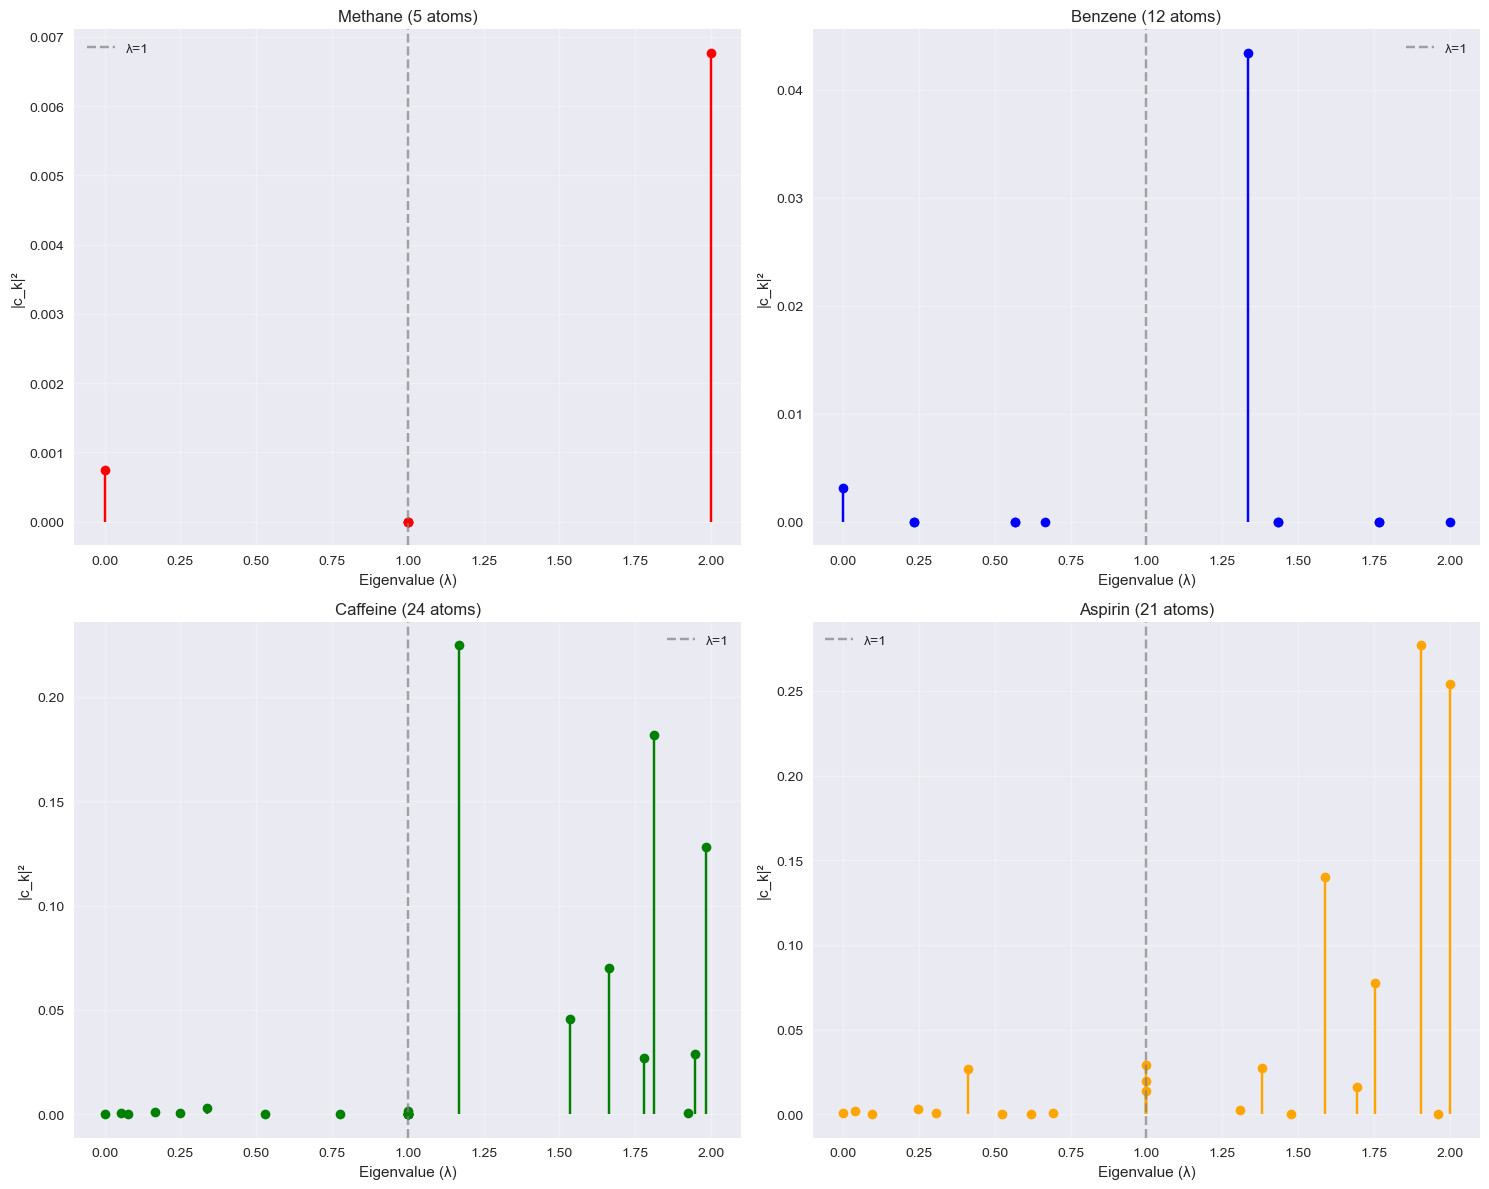

Spectral Centroids (measure of charge localization):
Benzene    (12 atoms): 1.244
Caffeine   (24 atoms): 1.598
Aspirin    (21 atoms): 1.724
Methane    ( 5 atoms): 1.800

Ranking (low to high charge localization):
1. Benzene (centroid = 1.244)
2. Caffeine (centroid = 1.598)
3. Aspirin (centroid = 1.724)
4. Methane (centroid = 1.800)


In [13]:
# Create a comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

colors = ['red', 'blue', 'green', 'orange']

for i, (name, data) in enumerate(mol_data.items()):
    ax = axes[i]
    evals = data['eigenvalues'] 
    coeffs = data['squared_coeffs']
    n_atoms = data['mol'].GetNumAtoms()
    
    # Plot spectrum
    ax.stem(evals, coeffs, basefmt=" ", linefmt=f'{colors[i]}', markerfmt='o')
    ax.set_xlabel('Eigenvalue (λ)')
    ax.set_ylabel('|c_k|²')
    ax.set_title(f'{name} ({n_atoms} atoms)')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.7, label='λ=1')
    ax.set_xlim(-0.1, 2.1)
    ax.legend()

plt.tight_layout()
plt.show()

# Spectral centroid comparison
print("Spectral Centroids (measure of charge localization):")
centroids = [(name, data['analysis']['spectral_centroid']) for name, data in mol_data.items()]
centroids.sort(key=lambda x: x[1])

for name, centroid in centroids:
    n_atoms = mol_data[name]['mol'].GetNumAtoms()
    print(f"{name:10s} ({n_atoms:2d} atoms): {centroid:.3f}")

print(f"\nRanking (low to high charge localization):")
for i, (name, centroid) in enumerate(centroids, 1):
    print(f"{i}. {name} (centroid = {centroid:.3f})")


In [14]:
# Create molecules of very different sizes
molecules = {
    "5CB": "CCCCCc1ccc(-c2ccc(C#N)cc2)cc1",                                    # Very small (5 atoms with H)
    "RM734": "COc1ccc(C(=O)Oc2ccc(C(=O)Oc3ccc([N+](=O)[O-])cc3)cc2)c(OC)c1"
}

# Process all molecules
mol_data = {}
for name, smiles in molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    n_generated = AllChem.EmbedMultipleConfs(mol, numConfs=n_conf, params=params)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol, maxIters=max_iters)

    
    # Compute charges
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol)
    charges = np.array([float(atom.GetProp('_GasteigerCharge')) for atom in mol.GetAtoms()])
    
    # Compute spectrum
    eigenvalues, squared_coeffs = compute_charge_spectrum(mol, charges)
    analysis = analyze_spectrum_features(eigenvalues, squared_coeffs)
    
    mol_data[name] = {
        'mol': mol,
        'charges': charges,
        'eigenvalues': eigenvalues,
        'squared_coeffs': squared_coeffs,
        'analysis': analysis
    }

# Display size comparison
print("Molecule size comparison:")
for name, data in mol_data.items():
    n_atoms = data['mol'].GetNumAtoms()
    evals = data['eigenvalues']
    print(f"{name:10s}: {n_atoms:2d} atoms, eigenvalues [{evals.min():.3f}, {evals.max():.3f}]")



Molecule size comparison:
5CB       : 38 atoms, eigenvalues [-0.000, 2.000]
RM734     : 48 atoms, eigenvalues [0.000, 2.000]


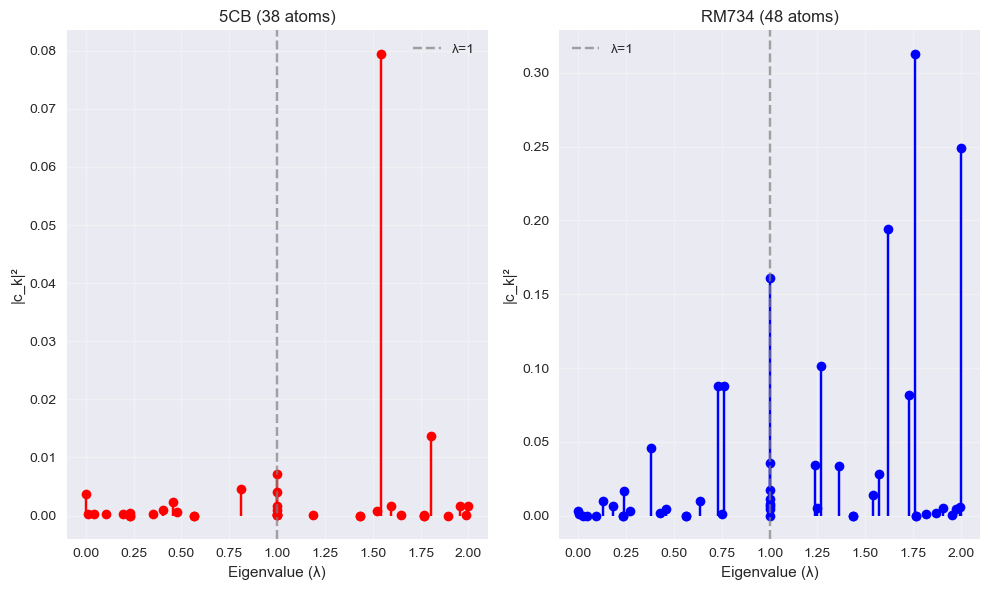

Spectral Centroids (measure of charge localization):
5CB        (38 atoms): 1.399
RM734      (48 atoms): 1.403

Ranking (low to high charge localization):
1. 5CB (centroid = 1.399)
2. RM734 (centroid = 1.403)


In [15]:
# Create a comprehensive comparison plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['red', 'blue']

for i, (name, data) in enumerate(mol_data.items()):
    ax = axes[i]
    evals = data['eigenvalues'] 
    coeffs = data['squared_coeffs']
    n_atoms = data['mol'].GetNumAtoms()
    
    # Plot spectrum
    ax.stem(evals, coeffs, basefmt=" ", linefmt=f'{colors[i]}', markerfmt='o')
    ax.set_xlabel('Eigenvalue (λ)')
    ax.set_ylabel('|c_k|²')
    ax.set_title(f'{name} ({n_atoms} atoms)')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.7, label='λ=1')
    ax.set_xlim(-0.1, 2.1)
    ax.legend()

plt.tight_layout()
plt.show()

# Spectral centroid comparison
print("Spectral Centroids (measure of charge localization):")
centroids = [(name, data['analysis']['spectral_centroid']) for name, data in mol_data.items()]
centroids.sort(key=lambda x: x[1])

for name, centroid in centroids:
    n_atoms = mol_data[name]['mol'].GetNumAtoms()
    print(f"{name:10s} ({n_atoms:2d} atoms): {centroid:.3f}")

print(f"\nRanking (low to high charge localization):")
for i, (name, centroid) in enumerate(centroids, 1):
    print(f"{i}. {name} (centroid = {centroid:.3f})")